In [1]:
import torch
from context import *
import matplotlib.pyplot as plt

In [156]:
from math import prod
class RGPredictor(torch.nn.Module):
    ''' RG flow-based predictive model
        
        Parameters:
            shape :: torch.Size - input shape
            dim :: int - input dimension
            out_dim :: int - output dimension
    '''
    def __init__(self, shape, dim, out_dim, **kwargs):
        super().__init__()
        self.rgflow = RGFlow(shape, dim, **kwargs)
        self._base_dist = ShapedNormal([dim, *self.rgflow.out_shape])
        self.para_size = prod(self._base_dist.event_shape)
        self.para_net = torch.nn.Sequential(
                            torch.nn.Linear(out_dim, 4*out_dim),
                            torch.nn.ReLU(),
                            torch.nn.Linear(4*out_dim, 2*self.para_size))
    
    def base_dist(self, y=None):
        if y is None:
            return self._base_dist
        else:
            para = self.para_net(y)
            loc = para[...,:self.para_size]
            scale = para[...,self.para_size:].exp()
            loc = loc.view(loc.shape[:-1]+self._base_dist.event_shape)
            scale = scale.view(scale.shape[:-1]+self._base_dist.event_shape)
            return self._base_dist.new(loc, scale)
    
    def log_prob(self, x, y=None, mode='jf', **kwargs):
        ''' log conditional probability estimation 
            Input:
                x :: torch.Tensor (N, dim, *shape) - data 
                y :: torch.Tensor (N, out_dim) - prediction
                     if y = None, returns log of marginal probability
            Ouput:
                log p(x|y) :: torch.Tensor (N,) - log probability '''
        z, logJ, *rest = self.rgflow.encode(x, mode=mode, **kwargs)
        logpz = self.base_dist(y).log_prob(z)
        return logpz + logJ
    
    def log_bayes(self, x, y, mode='f', **kwargs):
        ''' log Bayes factor estimation 
            log K(x|y) = log p(x|y) - log p(x)
            Input:
                x :: torch.Tensor (N, dim, *shape) - data 
                y :: torch.Tensor (N, out_dim) - prediction
            Ouput:
                log K(x|y) :: torch.Tensor (N,) - log Bayes factor '''
        z, *rest = self.rgflow.encode(x, mode=mode, **kwargs)
        logK = self.base_dist(y).log_prob(z) - self.base_dist().log_prob(z)
        return logK
    
    def nll_loss(self, x, y, lk=0.01, lg=0.01, mode='jf_reg', **kwargs):
        ''' compute negative log likelihood loss given training samples
            L = - log p(x|y) - log p(x) + regs...
            Input:
                x :: torch.Tensor (N, dim, *shape) - data 
                y :: torch.Tensor (N, out_dim) - prediction
                lk :: real - kinetic energy regularization strength
                lg :: real - gradient energy regularization strength
            Output:
                loss :: torch.Tensor (scalar) - regularized loss
                -logp :: torch.Tensor (scalar) - negative log likelihood
                Ek :: torch.Tensor (scalar) - kinetic energy
                Eg :: torch.Tensor (scalar) - gradient energy
        '''
        z, logJ, Ek, Eg = self.rgflow.encode(x, mode=mode, **kwargs)
        logpz_y = self.base_dist(y).log_prob(z)
        logpz = self.base_dist().log_prob(z)
        #logp = logpz_y + logpz + 2*logJ
        logp = logpz_y + logJ
        logp, Ek, Eg = [val.mean() for val in (logp, Ek, Eg)]
        return -logp + lk * Ek + lg * Eg, -logp, Ek, Eg

In [157]:
mdl = RGPredictor([1], 1, 1, hdims=[8,2], hyper_dim=8)
opt = torch.optim.Adam(mdl.parameters(), lr=0.01)
y = torch.tensor([[-1.],[1.]])
x = torch.tensor([[[-1.]],[[1.]]])

In [175]:
mdl.train()
opt.param_groups[0]['lr'] = 0.001
for _ in range(10):
    opt.zero_grad()
    out = mdl.nll_loss(x, y, lk=0.01, lg=0.01, atol=1e-3, rtol=1e-3)
    loss = out[0]
    loss.backward()
    opt.step()
    print(*[f'{o.item():5.2f}' for o in out])

-0.30 -0.32  0.50  1.88
-0.77 -0.80  0.58  2.50
-0.74 -0.77  0.57  2.53
-6.99 -7.14  0.47 14.46
 1.08  1.07  0.22  0.31
 0.43  0.41  0.21  1.51
 1.62  1.62  0.22  0.00
 1.64  1.64  0.23  0.01
 0.52  0.51  0.23  1.33
 0.80  0.79  0.22  1.04


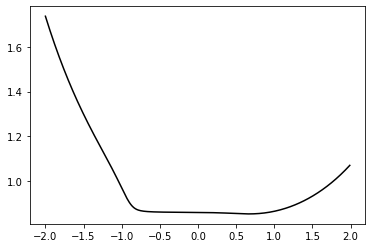

In [155]:
mdl.eval()
xs = torch.arange(-2,2,0.01)
with torch.no_grad():
    ps = mdl.log_bayes(xs.view(-1,1,1), torch.tensor([-1.]), div='exact').exp()
plt.plot(xs, ps, 'k-');

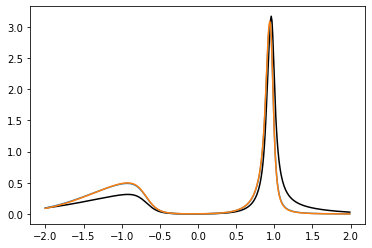

In [176]:
mdl.eval()
xs = torch.arange(-2,2,0.01)
with torch.no_grad():
    ps = mdl.log_prob(xs.view(-1,1,1), div='exact').exp()
plt.plot(xs, ps, 'k-');
with torch.no_grad():
    ps = mdl.log_prob(xs.view(-1,1,1), y[0], div='exact').exp()
plt.plot(xs, ps);
with torch.no_grad():
    ps = mdl.log_prob(xs.view(-1,1,1), y[1], div='exact').exp()
plt.plot(xs, ps);

In [80]:
mdl.base_dist(torch.tensor([1.])).dist.log_prob()

tensor([[[0.4388]]], grad_fn=<ExpandBackward0>)